# Explanations

This lab is based upon a demonstration of XGBoost, a tree-based learning algorithm. I'll ask you to analyze the results of this analysis, change the problem, and analyze the results. For details of the analysis, see today's in-class lecture. 

## Census income classification with XGBoost

This notebook demonstrates how to use XGBoost to predict the probability of an individual making over $50K a year in annual income. It uses the standard UCI Adult income dataset. To download a copy of the complete notebook visit [github](https://github.com/shap/shap/tree/master/notebooks).

Gradient boosting machine methods such as XGBoost are state-of-the-art for these types of prediction problems with tabular style input data of many modalities. Tree SHAP ([arXiv paper](https://arxiv.org/abs/1802.03888)) allows for the exact computation of SHAP values for tree ensemble methods, and has been integrated directly into the C++ XGBoost code base. This allows fast exact computation of SHAP values without sampling and without providing a background dataset (since the background is inferred from the coverage of the trees).

Here we demonstrate how to use SHAP values to understand XGBoost model predictions. 

In [1]:
try: 
    import xgboost
except ModuleNotFoundError: 
    ! pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 11.0 MB/s eta 0:00:00a 0:00:01


In [2]:
try: 
    import shap
except ModuleNotFoundError: 
    ! pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.3/455.3 kB 9.8 MB/s eta 0:00:00ta 0:00:01


In [3]:
import matplotlib.pylab as pl
import numpy as np
import xgboost
from sklearn.model_selection import train_test_split

import shap

# print the JS visualization code to the notebook
shap.initjs()

## Load dataset

In [4]:
X, y = shap.datasets.adult()
X_display, y_display = shap.datasets.adult(display=True)

# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
d_train = xgboost.DMatrix(X_train, label=y_train)
d_test = xgboost.DMatrix(X_test, label=y_test)

## Train the model

In [5]:
params = {
    "eta": 0.01,
    "objective": "binary:logistic",
    "subsample": 0.5,
    "base_score": np.mean(y_train),
    "eval_metric": "logloss",
}
model = xgboost.train(
    params,
    d_train,
    5000,
    evals=[(d_test, "test")],
    verbose_eval=100,
    early_stopping_rounds=20,
)

[0]	test-logloss:0.54663
[100]	test-logloss:0.36398
[200]	test-logloss:0.31758
[300]	test-logloss:0.30065
[400]	test-logloss:0.29170
[500]	test-logloss:0.28655
[600]	test-logloss:0.28358
[700]	test-logloss:0.28174
[800]	test-logloss:0.28061
[900]	test-logloss:0.27988
[1000]	test-logloss:0.27939
[1100]	test-logloss:0.27906
[1178]	test-logloss:0.27887


## Classic feature attributions

Here we try out the global feature importance calcuations that come with XGBoost. Note that they all contradict each other, which motivates the use of SHAP values since they come with consistency gaurentees (meaning they will order the features correctly).

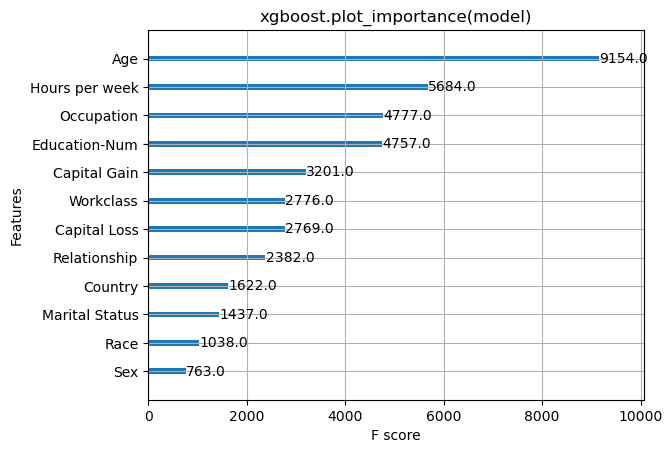

In [6]:
xgboost.plot_importance(model)
pl.title("xgboost.plot_importance(model)")
pl.show()

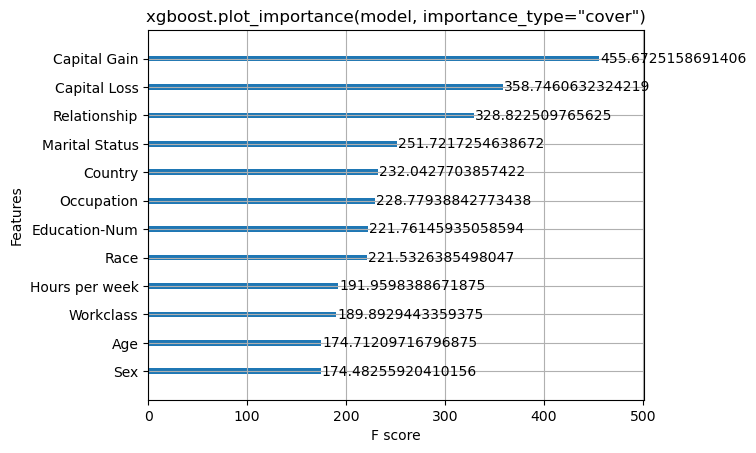

In [7]:
xgboost.plot_importance(model, importance_type="cover")
pl.title('xgboost.plot_importance(model, importance_type="cover")')
pl.show()

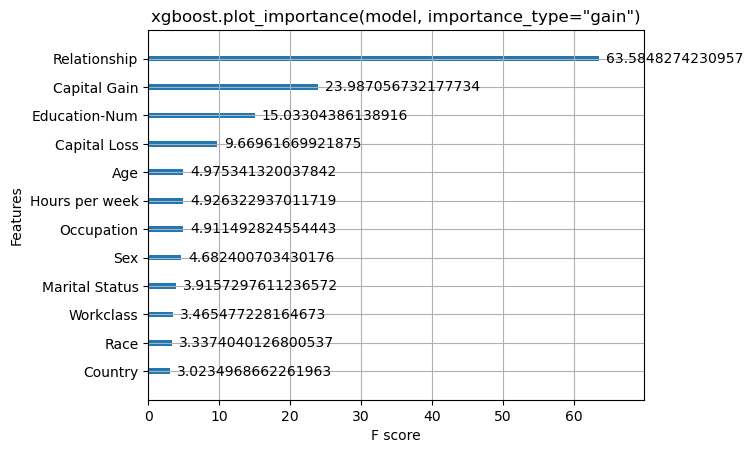

In [8]:
xgboost.plot_importance(model, importance_type="gain")
pl.title('xgboost.plot_importance(model, importance_type="gain")')
pl.show()

## Explain predictions

Here we use the Tree SHAP implementation integrated into XGBoost to explain the entire dataset (32561 samples).

In [14]:
# this takes a minute or two since we are explaining over 30 thousand samples in a model with over a thousand trees
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

### Visualize a single prediction

Note that we use the "display values" data frame so we get nice strings instead of category codes. 

In [10]:
shap.force_plot(explainer.expected_value, shap_values[0, :], X_display.iloc[0, :])

### Visualize many predictions

To keep the browser happy we only visualize 1,000 individuals.

In [11]:
shap.force_plot(explainer.expected_value, shap_values[:1000, :], X_display.iloc[:1000, :])

## Bar chart of mean importance

This takes the average of the SHAP value magnitudes across the dataset and plots it as a simple bar chart.

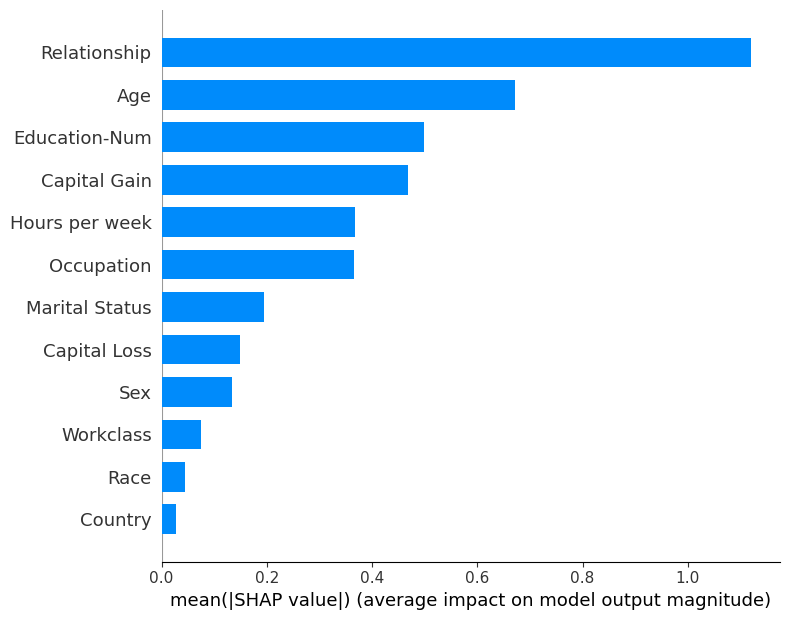

In [12]:
shap.summary_plot(shap_values, X_display, plot_type="bar")

## SHAP Summary Plot

Rather than use a typical feature importance bar chart, we use a density scatter plot of SHAP values for each feature to identify how much impact each feature has on the model output for individuals in the validation dataset. Features are sorted by the sum of the SHAP value magnitudes across all samples. It is interesting to note that the relationship feature has more total model impact than the captial gain feature, but for those samples where capital gain matters it has more impact than age. In other words, capital gain effects a few predictions by a large amount, while age effects all predictions by a smaller amount.

Note that when the scatter points don't fit on a line they pile up to show density, and the color of each point represents the feature value of that individual.

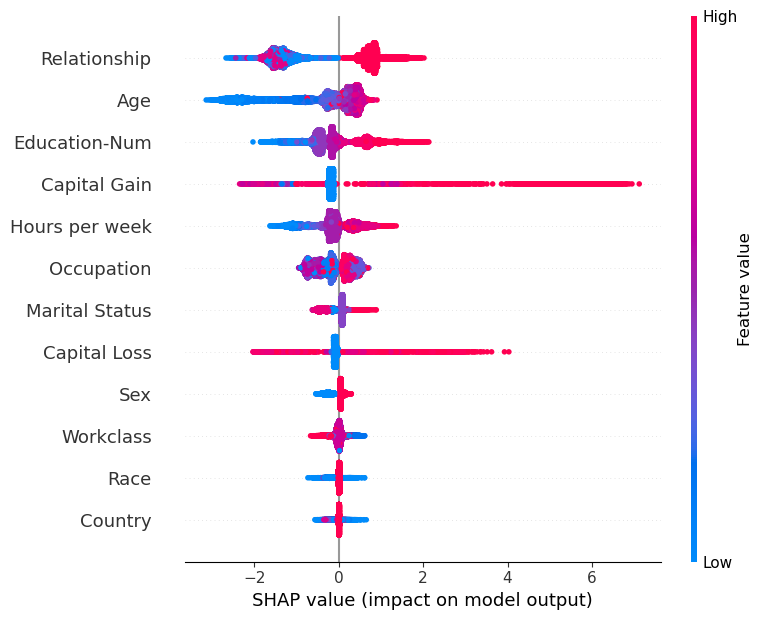

In [15]:
shap.summary_plot(shap_values, X)

## SHAP Dependence Plots

SHAP dependence plots show the effect of a single feature across the whole dataset. They plot a feature's value vs. the SHAP value of that feature across many samples. SHAP dependence plots are similar to partial dependence plots, but account for the interaction effects present in the features, and are only defined in regions of the input space supported by data. The vertical dispersion of SHAP values at a single feature value is driven by interaction effects, and another feature is chosen for coloring to highlight possible interactions.

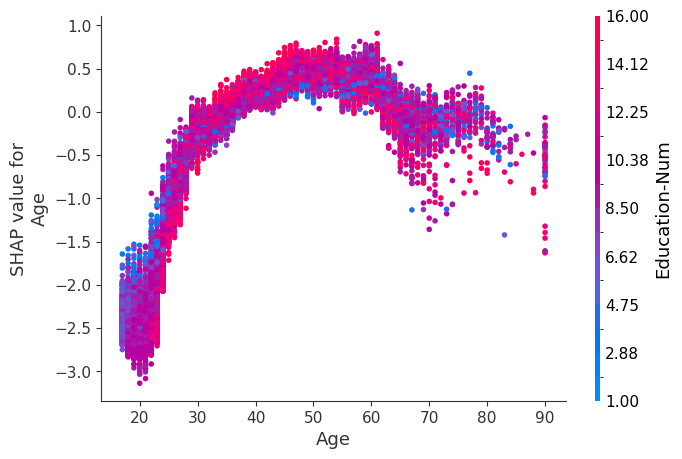

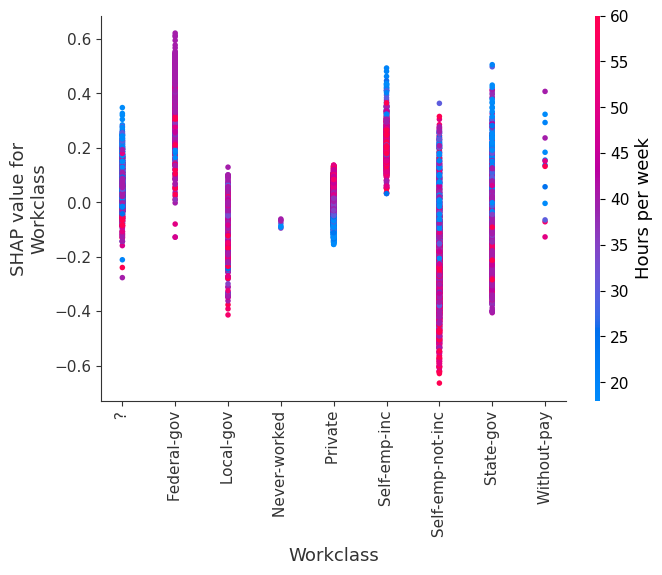

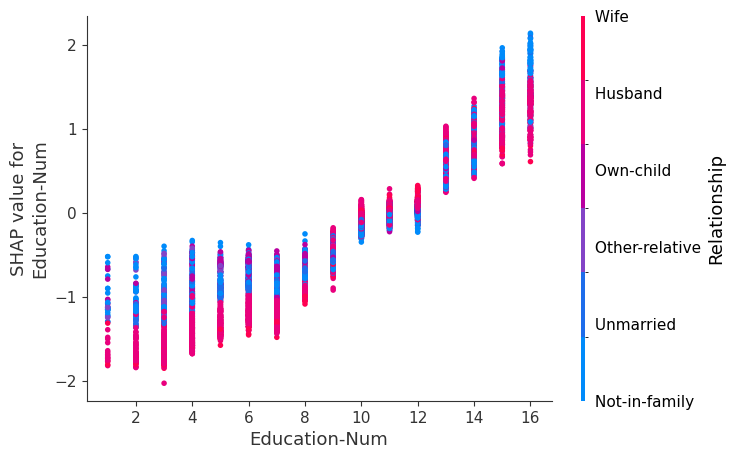

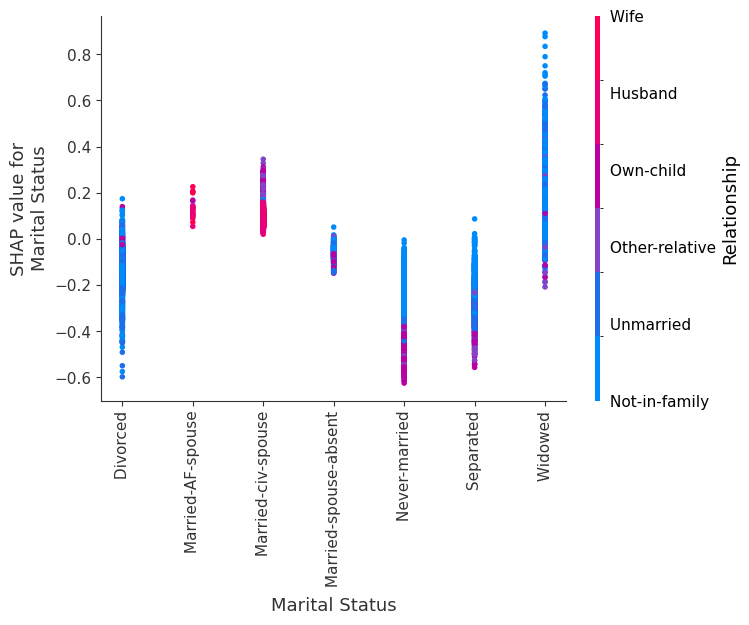

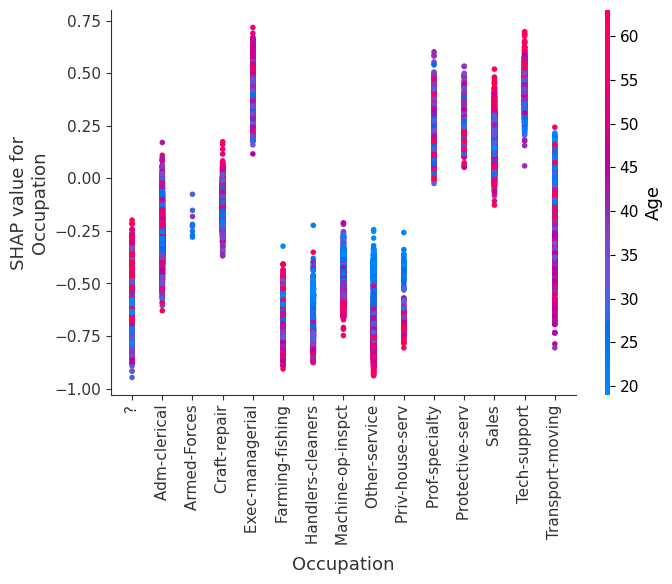

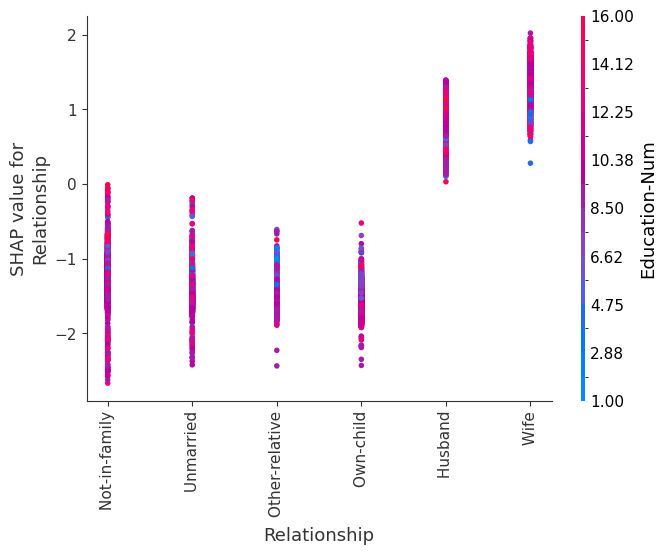

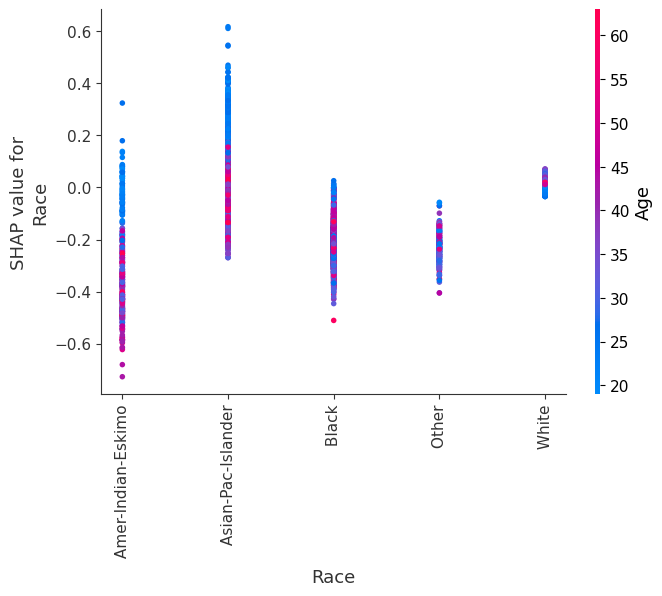

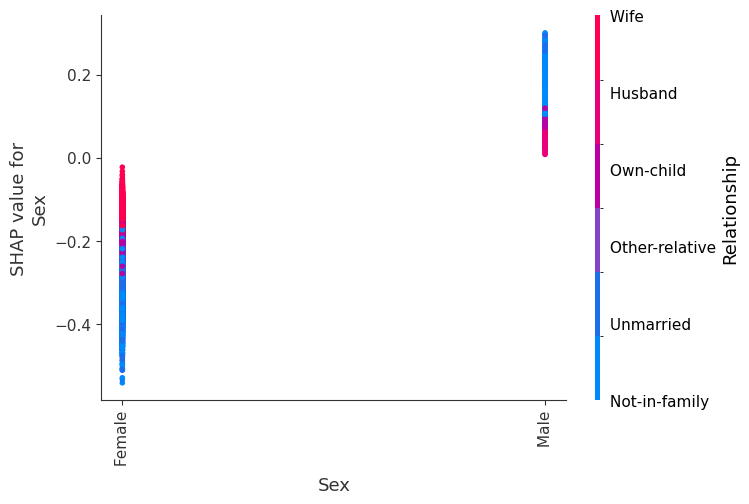

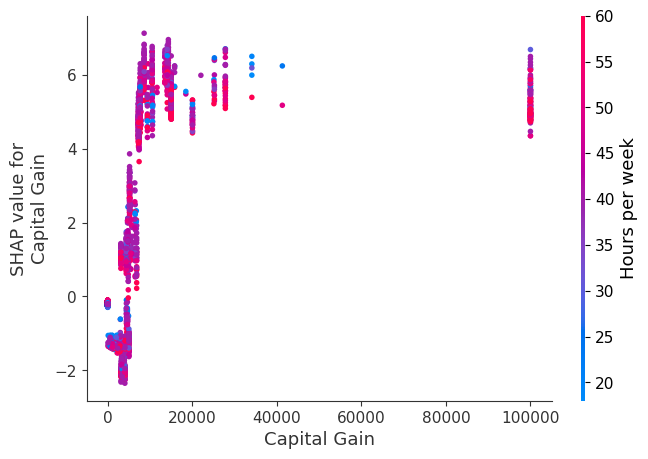

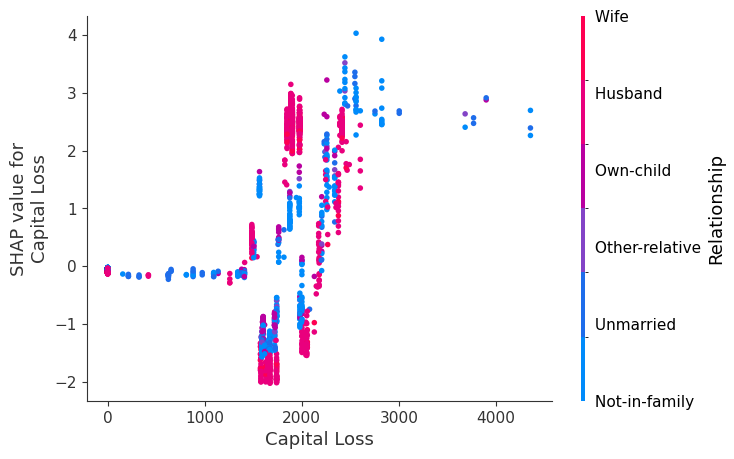

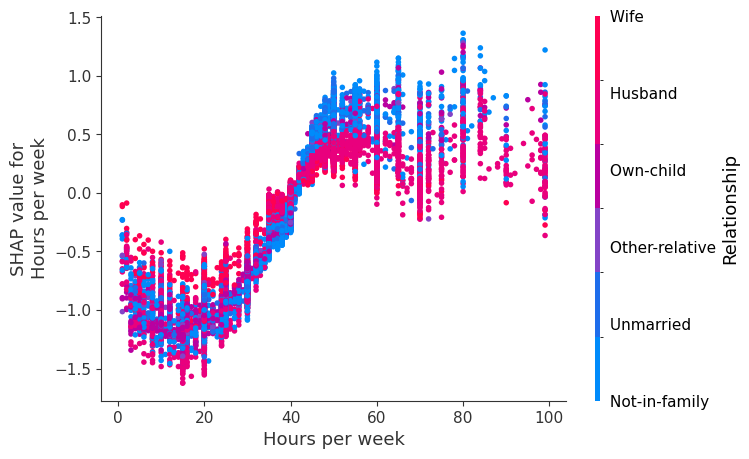

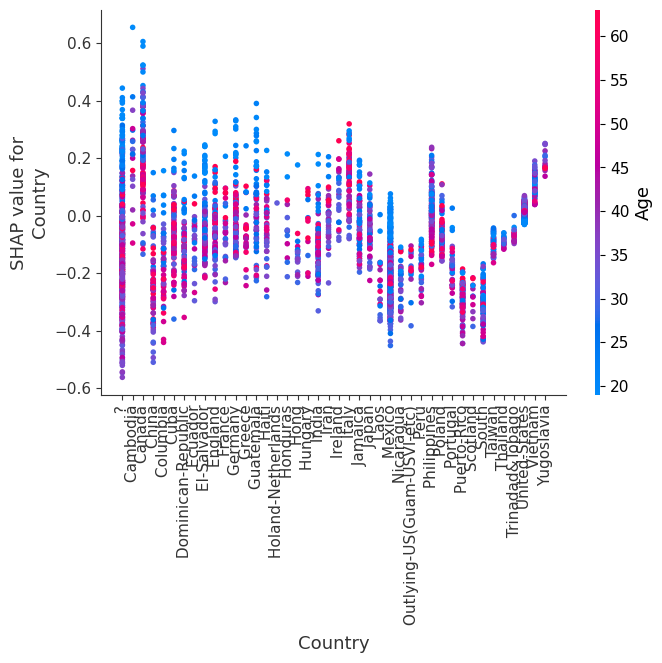

In [16]:
for name in X_train.columns:
    shap.dependence_plot(name, shap_values, X, display_features=X_display)

__Question 1__: What are the dominant columns with respect to the single decision variable (income > $50k)? 

*Your answer:* 
The plot indicates that Age and Education-Num are dominant columns for predicting income > $50K. Age remains a dominant column with strong predictive power. Education-Num interacts with Age and contributes significantly. Country is also a dominant feature, with significant variation in SHAP values across different countries.

__Question 2__: Rerun the analysis above after deleting the columns "Capital Gain" and "Capital Loss" from the dataset. 
Display the summary as before. 

In [ ]:
# BEGIN SOLUTION

[0]	test-logloss:0.54733
[100]	test-logloss:0.39241
[200]	test-logloss:0.35553
[300]	test-logloss:0.34327
[400]	test-logloss:0.33842
[500]	test-logloss:0.33649
[600]	test-logloss:0.33574
[640]	test-logloss:0.33569
SHAP Summary Plot (Bar Chart)


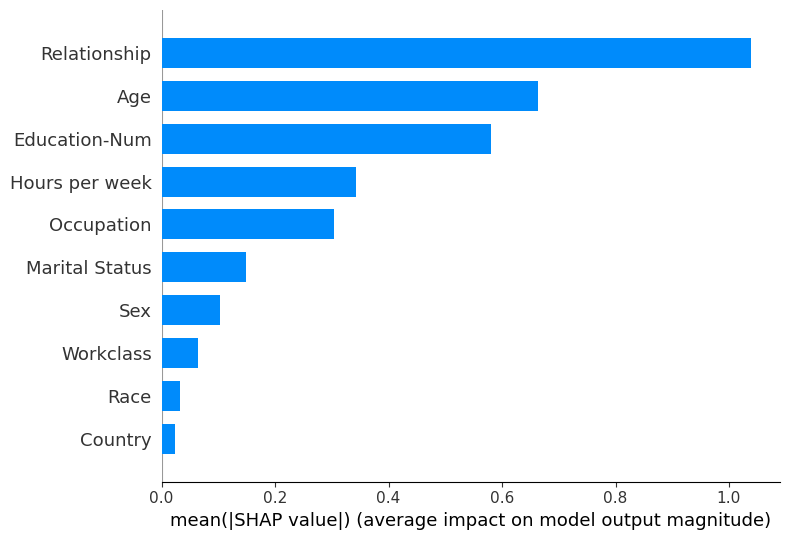

SHAP Summary Plot (Scatter Plot)


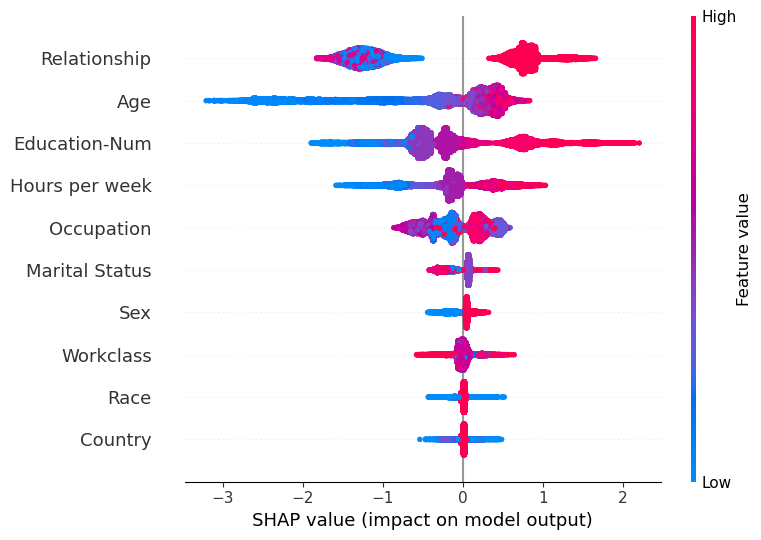

In [21]:
# ... put your solution here. Use as many cells as you want...
# Remove 'Capital Gain' and 'Capital Loss' from the dataset
X_modified = X.drop(columns=["Capital Gain", "Capital Loss"])
X_display_modified = X_display.drop(columns=["Capital Gain", "Capital Loss"])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_modified, y, test_size=0.2, random_state=7)
d_train = xgboost.DMatrix(X_train, label=y_train)
d_test = xgboost.DMatrix(X_test, label=y_test)

# XGBoost model training
params = {
    "eta": 0.01,
    "objective": "binary:logistic",
    "subsample": 0.5,
    "base_score": np.mean(y_train),
    "eval_metric": "logloss",
}
model = xgboost.train(
    params,
    d_train,
    5000,
    evals=[(d_test, "test")],
    verbose_eval=100,
    early_stopping_rounds=20,
)

# SHAP analysis
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_modified)

# SHAP summary plot (bar chart and scatter plot)
print("SHAP Summary Plot (Bar Chart)")
shap.summary_plot(shap_values, X_display_modified, plot_type="bar")

print("SHAP Summary Plot (Scatter Plot)")
shap.summary_plot(shap_values, X_modified)

In [ ]:
# END SOLUTION

__Question 3__: What are the dominant columns in determining income now? 

*Your answer:* The dominant columns in determining income after removing Capital Gain and Capital Loss are Relationship, Age, Education-Num, Hours per Week, and Occupation. Relationship has the highest impact, followed by Age and Education-Num, as shown by their mean SHAP values. These features now play the largest role in predicting whether income exceeds $50K.

__Question 4__: What are the protected columns in this dataset according to US law (i.e., what columns are prohibited from discrimatory use.) 

*Your answer:* The protected columns in this dataset according to US law are Race, Sex, Age, Country (or National Origin), and potentially Marital Status. These columns are protected under laws such as the Civil Rights Act of 1964, the Age Discrimination in Employment Act (ADEA), and various state laws, which prohibit their use in discriminatory decisions like hiring, housing, or credit approval.

__Question 5__: If we delete the protected columns, how does accuracy change? 

In [ ]:
# BEGIN SOLUTION

In [19]:
# ... put your solution here. Use as many cells as you want...
from sklearn.metrics import accuracy_score

# Define protected columns
protected_columns = ["Race", "Sex", "Age", "Country", "Marital Status"]

# Remove protected columns from the dataset
X_no_protected = X.drop(columns=protected_columns)
X_display_no_protected = X_display.drop(columns=protected_columns)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_no_protected, y, test_size=0.2, random_state=7)
d_train = xgboost.DMatrix(X_train, label=y_train)
d_test = xgboost.DMatrix(X_test, label=y_test)

# Train XGBoost model
model_no_protected = xgboost.train(
    params,
    d_train,
    5000,
    evals=[(d_test, "test")],
    verbose_eval=100,
    early_stopping_rounds=20,
)

# Predict on test data
y_pred = model_no_protected.predict(d_test)
y_pred_binary = [1 if p > 0.5 else 0 for p in y_pred]

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print("Accuracy after removing protected columns:", accuracy)

[0]	test-logloss:0.54663
[100]	test-logloss:0.36808
[200]	test-logloss:0.32420
[300]	test-logloss:0.30863
[400]	test-logloss:0.30135
[500]	test-logloss:0.29730
[600]	test-logloss:0.29513
[700]	test-logloss:0.29382
[800]	test-logloss:0.29312
[900]	test-logloss:0.29253
[1000]	test-logloss:0.29209
[1087]	test-logloss:0.29196
Accuracy after removing protected columns: 0.8681099339781975


ANSWER:

After removing the protected columns (Race, Sex, Age, Country, and Marital Status), the model achieved an accuracy of 86.81%. This indicates that while the accuracy has likely decreased slightly compared to the original model (where protected features were included), the model still performs well.

The very small decrease in accuracy suggests that the protected columns provided some predictive value, likely because they correlate with income. However, removing them ensures compliance with anti-discrimination laws and produces a model that is fairer and more ethical. The remaining features, such as Relationship, Education-Num, and Hours per Week, are now driving the predictions.

In [23]:
# END SOLUTION